# Introduction
This notebook's purpose is to show ROC(receiver operating characteristic) curve for each of our models.

## Prepare environment

In [66]:
import os
import torch
import pandas as pd

from typing import Type
from matplotlib import pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.metrics import roc_curve, auc

from dataset.dataset_type import DatasetType
from dataset.dataset_info import DatasetInfo, MMClassifierDatasetInfo
from files_handler.model_files_handler import ModelFilesHandler

os.chdir(r"D:\Projects\studia\polsl_ssi_1\MethaneDetection\Thesis")
device = "cuda" if torch.cuda.is_available() else "cpu"

## Prepare dataset class

In [67]:
class STARCOPDataset(Dataset):
    def __init__(
            self,
            data_path: str,
            data_type: DatasetType,
            image_info_class: Type[DatasetInfo],
            crop_size: int = 1,
    ):
        self.images_path = os.path.join(data_path, data_type.get_folder_name(), data_type.get_folder_name())
        self.image_info = image_info_class
        self.csv = pd.read_csv(os.path.join(data_path, data_type.value + ".csv"))
        self.crop_size = crop_size

    def __len__(self):
        return len(self.csv) * (self.crop_size * self.crop_size)

    def __getitem__(self, index):
        return self._get_raw_item(index)

    def _get_raw_item(self, index):
        file_index = index // (self.crop_size * self.crop_size)
        images_directory_path = os.path.join(self.images_path, self.csv["id"][file_index])

        return self.image_info.load_tensor(
            images_directory_path,
            grid_id=index % (self.crop_size * self.crop_size),
            crop_size=self.crop_size
        )

## Create dataloaders

In [68]:
dataset = STARCOPDataset(
    data_path=r"data",
    data_type=DatasetType.TEST,
    image_info_class=MMClassifierDatasetInfo,
)

dataloader = DataLoader(dataset, batch_size=6, shuffle=False)
model_handler = ModelFilesHandler()

## Function for plotting ROC curve

In [69]:
def show_roc_curve(probabilities, labels):
    fpr, tpr, thresholds = roc_curve(labels, probabilities)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label="Random guess")

    plt.title("Receiver Operating Characteristic (ROC) Curve", fontsize=16)
    plt.xlabel("False Positive Rate (FPR)", fontsize=14)
    plt.ylabel("True Positive Rate (TPR)", fontsize=14)
    plt.legend(loc="lower right", fontsize=12)
    plt.grid(True)
    plt.show()

## Create ROC for CNN

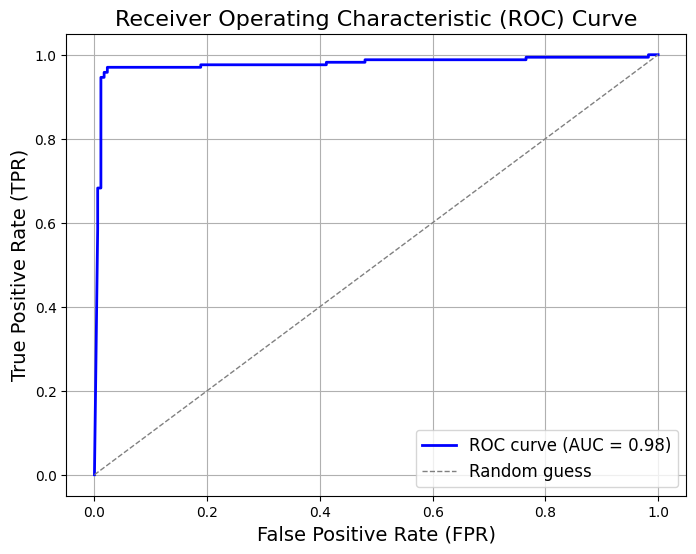

In [70]:
file_name = r"best_models\CNN\model_cnn_2024_12_14_13_20_07.pickle"
cnn_model, _, _, _ = model_handler.load_model(file_name=file_name)

cnn_model.eval()
cnn_model.to(device)

all_probabilities = []
all_labels = []
for id, image in enumerate(dataloader):
    (tensor_AVIRIS, tensor_mag1c, filtered_image, label) = image
    input_image = torch.cat((tensor_AVIRIS, tensor_mag1c), dim=1).to(device)
    labels = label.long().to(device)

    outputs = cnn_model(input_image).cpu().detach().numpy()
    probabilities = outputs[:, 1].tolist()
    all_probabilities.extend(probabilities)
    all_labels.extend(label.numpy().tolist())

cnn_model = cnn_model.to("cpu")
show_roc_curve(all_probabilities, all_labels)

## Create ROC for DETR

D:\Projects\studia\polsl_ssi_1\MethaneDetection\Thesis\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


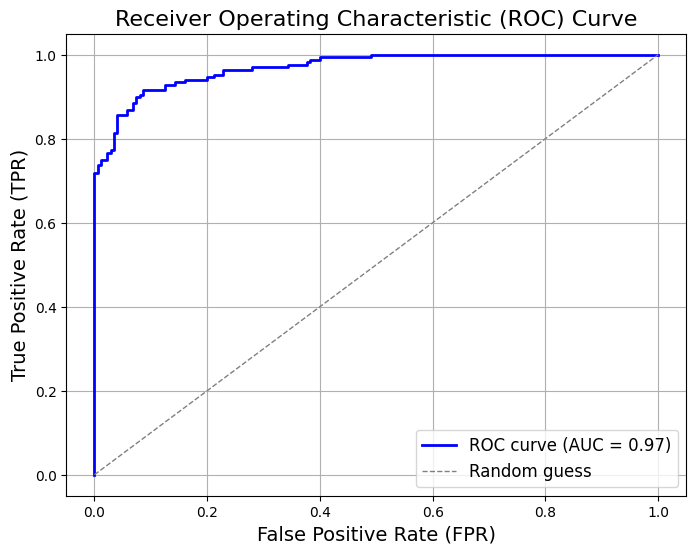

In [71]:
file_name = r"best_models\DETR\model_detr_2024_12_15_11_35_17.pickle"
detr_model, _, _, _ = model_handler.load_model(file_name=file_name)

detr_model.eval()
detr_model.to(device)

all_probabilities = []
for id, image in enumerate(dataloader):
    (tensor_AVIRIS, tensor_mag1c, filtered_image, label) = image
    input_image = torch.cat((tensor_AVIRIS, tensor_mag1c), dim=1).to(device)
    labels = label.long().to(device)

    outputs = detr_model(input_image).cpu().detach().numpy()
    probabilities = outputs[:, 1].tolist()
    all_probabilities.extend(probabilities)

detr_model = detr_model.to("cpu")
show_roc_curve(all_probabilities, all_labels)

## Create ROC for Methane Mapper

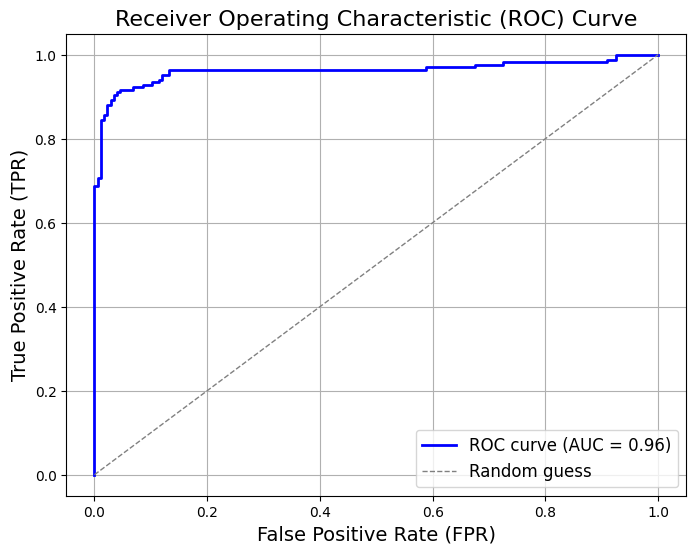

In [72]:
file_name = r"best_models\MethaneMapper\model_transformer_classifier_2024_12_02_00_37_54.pickle"
mm_model, _, _, _ = model_handler.load_model(file_name=file_name)

mm_model.eval()
mm_model.to(device)

all_probabilities = []
for id, image in enumerate(dataloader):
    (tensor_AVIRIS, tensor_mag1c, filtered_image, label) = image
    input_image = torch.cat((tensor_AVIRIS, tensor_mag1c), dim=1).to(device)
    filtered_image = filtered_image.to(device)
    labels = label.long().to(device)

    outputs = mm_model(input_image, filtered_image).cpu().detach().numpy()
    probabilities = outputs[:, 1].tolist()
    all_probabilities.extend(probabilities)

mm_model = mm_model.to("cpu")
show_roc_curve(all_probabilities, all_labels)

## Create ROC for ViT

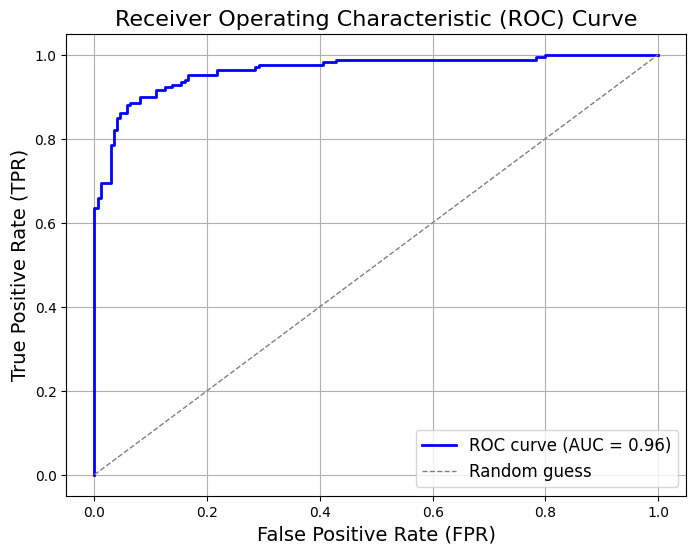

In [73]:
file_name = r"best_models\VIT\model_vit_2024_12_15_11_50_56.pickle"
vit_model, _, _, _ = model_handler.load_model(file_name=file_name)

vit_model.eval()
vit_model.to(device)

all_probabilities = []
for id, image in enumerate(dataloader):
    (tensor_AVIRIS, tensor_mag1c, filtered_image, label) = image
    input_image = torch.cat((tensor_AVIRIS, tensor_mag1c), dim=1).to(device)
    labels = label.long().to(device)

    outputs = vit_model(input_image).cpu().detach().numpy()
    probabilities = outputs[:, 1].tolist()
    all_probabilities.extend(probabilities)

vit_model = vit_model.to("cpu")
show_roc_curve(all_probabilities, all_labels)